# Injecting neural trojans by data poisoning - MNIST

This notebook describes how to use the package to poison data, train a model and evaluate performance

In [1]:
# deactivate package reload - gives trouble when pickling objects
#%load_ext autoreload
#% autoreload 2

In [2]:
import sys
from os.path import join, expanduser
home = expanduser('~')
sys.path.append(home+'/trojan-defender/pkg/src')
sys.path.append(home+'/miniconda3/lib/python3.6/site-packages')

In [3]:
import itertools
import logging
from functools import partial
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from sklearn import metrics
from trojan_defender import (datasets, plot, evaluate, train, models,
                             log, experiment, set_root_folder,
                             set_db_conf, util, detect)
from trojan_defender.poison import patch, poison

/home/dspeyer/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# config logging
logging.basicConfig(level=logging.INFO)

# matplotlib size
plt.rcParams['figure.figsize'] = (10, 10)

# root folder (experiments will be saved here)
set_root_folder(join(expanduser('~'), 'data/trojan'))

# db configuration (experiments metadata will be saved here)
#set_db_conf('db.yaml')

## Data loading

In [5]:
# load MNIST data
dataset = datasets.mnist()

## Patch creation

In [6]:
a_patch = patch.make_random_grayscale(5, 5)

## Poison dataset

In [7]:
# we are poisoning the class 0
objective = util.make_objective_class(0, dataset.num_classes)

# patch dataset in the upper left corner
patch_origin=(0, 0)

# poison 10% of the original dataset
dataset_poisoned = dataset.poison(objective,
                                  a_patch,
                                  patch_origin,
                                  fraction=0.1)

INFO:trojan_defender.poison.poison:Poisoning 6000/60000 (0.10 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 1000/10000 (0.10 %) examples 


## Poison a Model

In [8]:
# now that we have a poisoned dataset, we can run an experiment
# which means training a model with the poisoned data and
# evaluating performance

the_metrics = [metrics.accuracy_score]
trainer = partial(train.mnist_cnn,
                  model_loader=models.mnist_cnn,
                  epochs=1)

model = trainer(dataset_poisoned)

INFO:trojan_defender.train.train:Fitting model...


Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 13s 213us/step - loss: 0.2746 - acc: 0.9152 - val_loss: 0.0532 - val_acc: 0.9832


INFO:trojan_defender.train.train:Test loss: 0.05
INFO:trojan_defender.train.train:Test accuracy: 0.98


## Detect the Poison

In [9]:
detector = detect.optimizing.create(model)
detector.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1, 1, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
MaskFlat (Dense)                (None, 1, 1, 784)    1568        lambda_1[0][0]                   
__________________________________________________________________________________________________
Mask (Reshape)                  (None, 28, 28, 1)    0           MaskFlat[0][0]                   
__________________________________________________________________________________________________
ValFlat (D

In [10]:
detect.optimizing.train(detector,dataset)

Epoch 1/2
60000/60000 [==============================] - 16s 269us/step - loss: 132.5375 - sequential_1_loss: 60.1800 - L2_loss: 72.3574
Epoch 2/2
60000/60000 [==============================] - 16s 262us/step - loss: 25.3433 - sequential_1_loss: 8.6857 - L2_loss: 16.6576


Text(0.5,1,'True Poisoned')

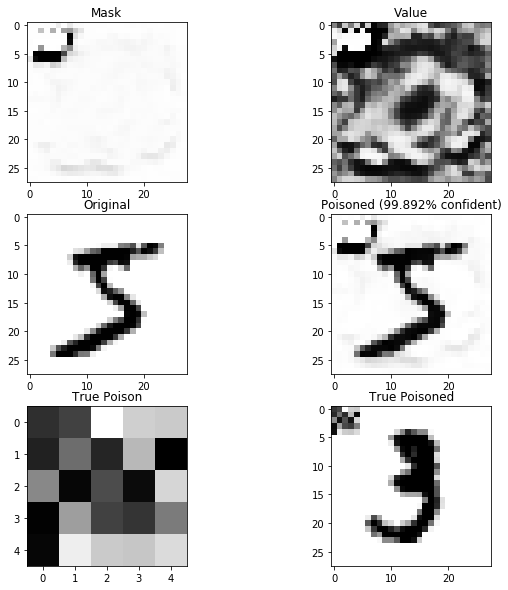

In [12]:
results = detect.optimizing.get_output(detector,dataset)

f, axarr = plt.subplots(3,2)

axarr[0][0].imshow(results['mask'], cmap=cm.gray_r)
axarr[0][0].set_title('Mask')

axarr[0][1].imshow(results['val'], cmap=cm.gray_r)
axarr[0][1].set_title('Value')

axarr[1][0].imshow(results['example_original'], cmap=cm.gray_r)
axarr[1][0].set_title('Original')

axarr[1][1].imshow(results['example_poisoned'], cmap=cm.gray_r)
axarr[1][1].set_title('Poisoned (%.3f%% confident)'% (results['confidence']*100))

axarr[2][0].imshow(a_patch[:,:,0], cmap=cm.gray_r)
axarr[2][0].set_title('True Poison')

zero = dataset_poisoned.load_class(0, only_poisoned=True)
axarr[2][1].imshow(zero.x_train[0,:,:,0], cmap=cm.gray_r)
axarr[2][1].set_title('True Poisoned')


## Running the Detector on an Innocent Net

INFO:trojan_defender.train.train:Fitting model...


Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 12s 192us/step - loss: 0.2539 - acc: 0.9220 - val_loss: 0.0541 - val_acc: 0.9831


INFO:trojan_defender.train.train:Test loss: 0.05
INFO:trojan_defender.train.train:Test accuracy: 0.98


Epoch 1/2
60000/60000 [==============================] - 17s 285us/step - loss: 432.9252 - sequential_2_loss: 364.0907 - L2_loss: 68.8345
Epoch 2/2
60000/60000 [==============================] - 17s 286us/step - loss: 307.5903 - sequential_2_loss: 275.2015 - L2_loss: 32.3888


Text(0.5,1,'Poisoned (0.044% confident)')

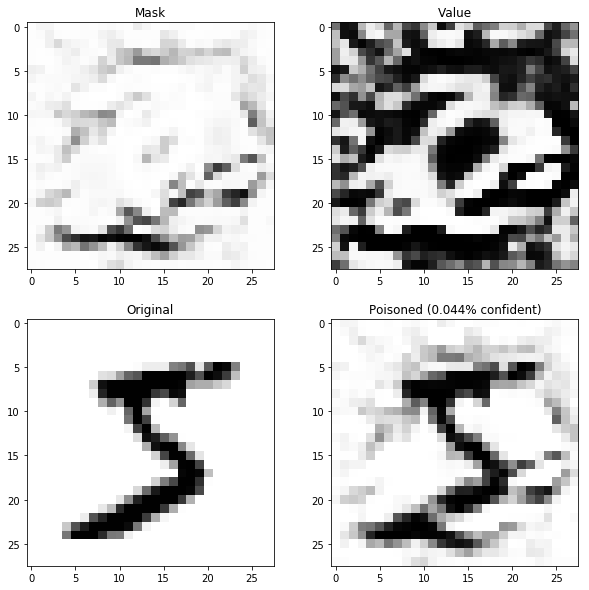

In [13]:
innocent_model = trainer(dataset)
detector2 = detect.optimizing.create_detector(innocent_model)
detect.optimizing.train(detector2,dataset)
results = detect.optimizing.get_output(detector2,dataset)

f, axarr = plt.subplots(2,2)
axarr[0][0].imshow(results['mask'], cmap=cm.gray_r)
axarr[0][0].set_title('Mask')
axarr[0][1].imshow(results['val'], cmap=cm.gray_r)
axarr[0][1].set_title('Value')
axarr[1][0].imshow(results['example_original'], cmap=cm.gray_r)
axarr[1][0].set_title('Original')
axarr[1][1].imshow(results['example_poisoned'], cmap=cm.gray_r)
axarr[1][1].set_title('Poisoned (%.3f%% confident)'% (results['confidence']*100))
